# 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle/input/kickstarter-projects\ks-projects-201612.csv
kaggle/input/kickstarter-projects\ks-projects-201801.csv


In [2]:
import seaborn as sns   # 이미지 라이브러리 임포트
import matplotlib.pyplot as plt # 이미지 라이브러리 임포트
%matplotlib inline

from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

import warnings
warnings.filterwarnings('ignore')   # 경고문구 제거

In [3]:
# read the data
ks_project = pd.read_csv('kaggle/input/kickstarter-projects/ks-projects-201801.csv')
ks_project.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [4]:
ks_project.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


# 데이터 전처리
- Dtypes 변경하기
- null값 채우기

In [5]:
ks_project['deadline'] = pd.to_datetime(ks_project['deadline'])
ks_project['launched'] = pd.to_datetime(ks_project['launched'])
ks_project.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ID                378661 non-null  int64         
 1   name              378657 non-null  object        
 2   category          378661 non-null  object        
 3   main_category     378661 non-null  object        
 4   currency          378661 non-null  object        
 5   deadline          378661 non-null  datetime64[ns]
 6   goal              378661 non-null  float64       
 7   launched          378661 non-null  datetime64[ns]
 8   pledged           378661 non-null  float64       
 9   state             378661 non-null  object        
 10  backers           378661 non-null  int64         
 11  country           378661 non-null  object        
 12  usd pledged       374864 non-null  float64       
 13  usd_pledged_real  378661 non-null  float64       
 14  usd_

In [6]:
print('Number of null')
print(ks_project.isnull().sum())
print('-'*100)
print('각 컬럼별 null 비율')
print(ks_project.isnull().sum() / len(ks_project) * 100)

Number of null
ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64
----------------------------------------------------------------------------------------------------
각 컬럼별 null 비율
ID                  0.000000
name                0.001056
category            0.000000
main_category       0.000000
currency            0.000000
deadline            0.000000
goal                0.000000
launched            0.000000
pledged             0.000000
state               0.000000
backers             0.000000
country             0.000000
usd pledged         1.002744
usd_pledged_real    0.000000
usd_goal_real       0.000000
dtype: float64


데이터 널값이 1% 미만이 되었다.

이제 널값이 분석에 미치는 영향이 적어졌으므로 널값을 지워버리도록 한다

In [7]:
ks_project_dropna = ks_project.dropna()

# 얼마나 많은 널값이 제거되었는지 확인한다
print('Number of null')
print(ks_project_dropna.isnull().sum())
print('-'*100)
print('각 컬럼별 null 비율')
print(ks_project_dropna.isnull().sum() / len(ks_project_dropna) * 100)

Number of null
ID                  0
name                0
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd pledged         0
usd_pledged_real    0
usd_goal_real       0
dtype: int64
----------------------------------------------------------------------------------------------------
각 컬럼별 null 비율
ID                  0.0
name                0.0
category            0.0
main_category       0.0
currency            0.0
deadline            0.0
goal                0.0
launched            0.0
pledged             0.0
state               0.0
backers             0.0
country             0.0
usd pledged         0.0
usd_pledged_real    0.0
usd_goal_real       0.0
dtype: float64


# 목표 변수의 데이터 분석
state 컬럼의 분포 상태를 확인한다

failed        52.715947
successful    35.706931
canceled      10.339060
live           0.746412
suspended      0.491650
Name: state, dtype: float64%



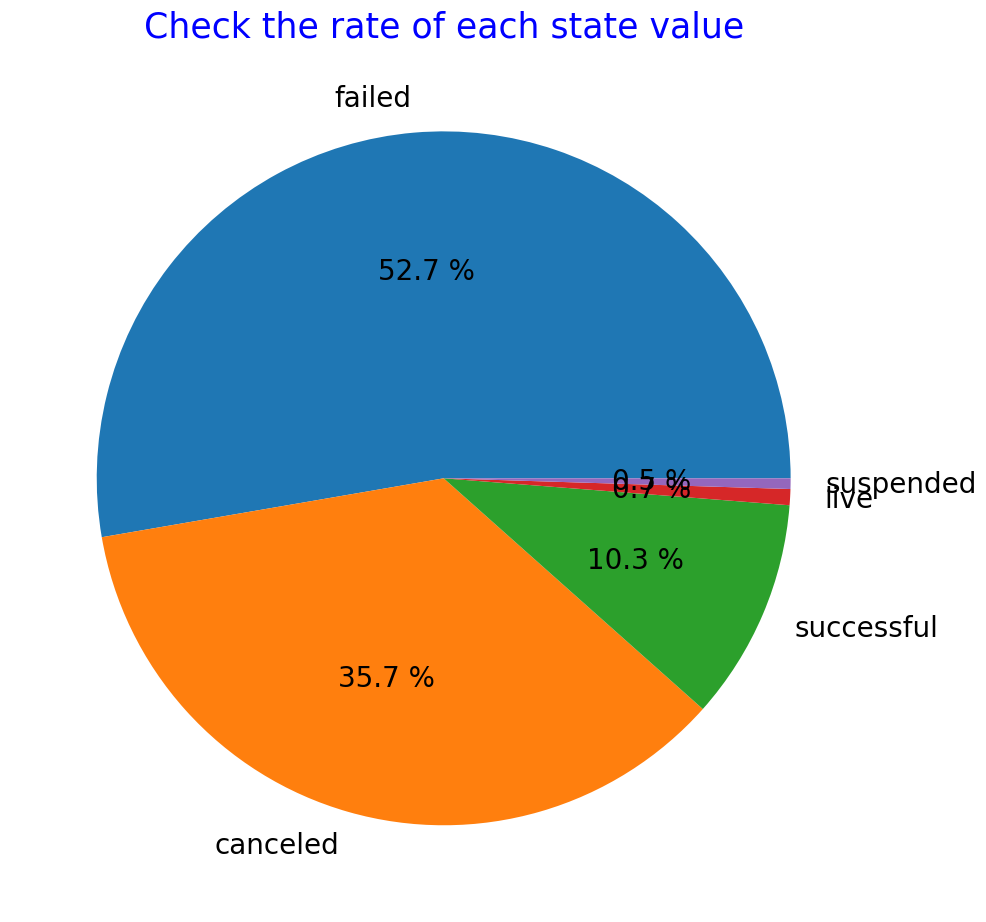

In [9]:
each_rate = ks_project_dropna['state'].value_counts() / len(ks_project_dropna['state']) * 100
print(f'{each_rate}%')
print()

figure = plt.figure(figsize=(10, 10))
plt.pie(ks_project_dropna['state'].value_counts(), labels=ks_project_dropna['state'].unique(), autopct="%1.1f %%", textprops={"size": 20})
plt.title('Check the rate of each state value', fontsize=25, color='blue')
plt.tight_layout()

- 성공이냐 실패만을 두고 데이터 판단을 하고 싶음
- suspended, canceled의 상태는 fail로 처리한다

In [10]:
ks_project_dropna = ks_project_dropna.replace({'state': {'canceled': 'failed', 'suspended': 'failed'}}) # canceled, suspended 변경
ks_project_dropna = ks_project_dropna[ks_project_dropna.state.isin(['failed', 'successful'])] # failed, successful 포함 데이터 가져오기
ks_project_dropna['state'].value_counts()   # 작업 후 확인

failed        238211
successful    133851
Name: state, dtype: int64

failed        64.024544
successful    35.975456
Name: state, dtype: float64%



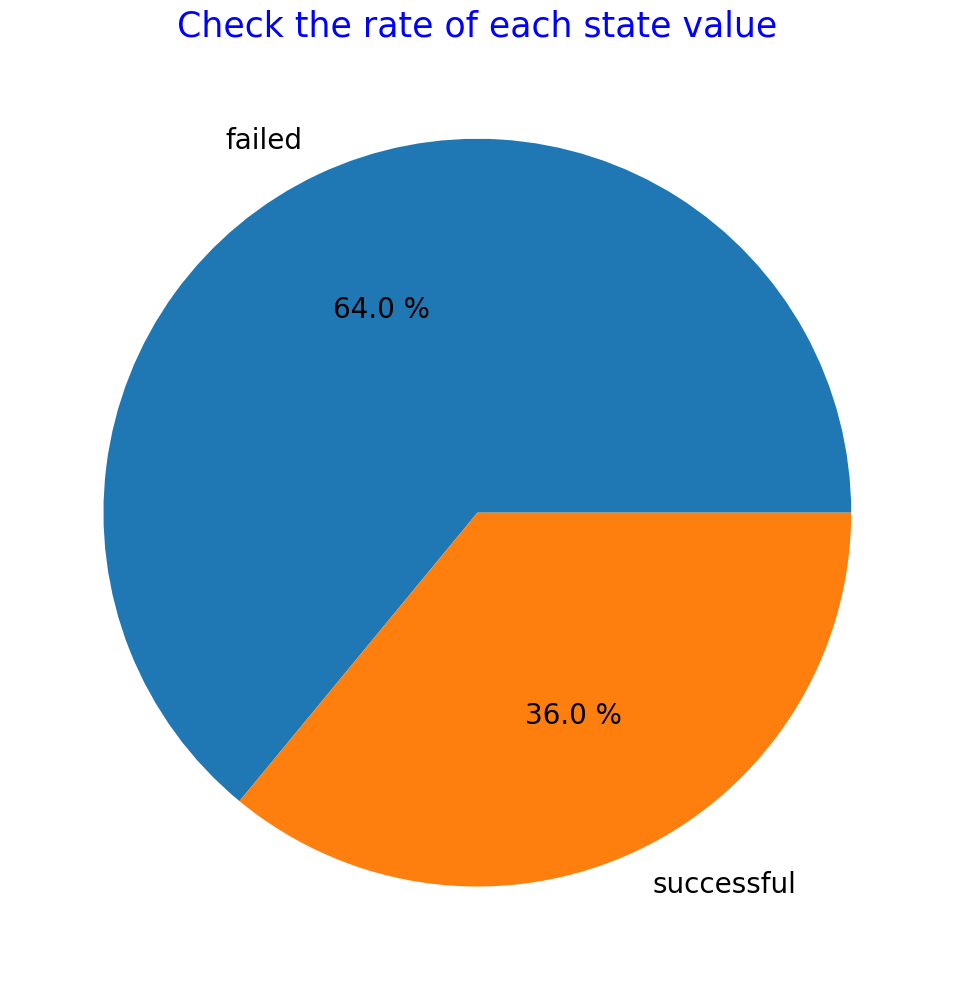

In [11]:
each_rate = ks_project_dropna['state'].value_counts() / len(ks_project_dropna['state']) * 100
print(f'{each_rate}%')
print()

figure = plt.figure(figsize=(10, 10))
plt.pie(ks_project_dropna['state'].value_counts(), labels=ks_project_dropna['state'].unique(), autopct="%1.1f %%", textprops={"size": 20})
plt.title('Check the rate of each state value', fontsize=25, color='blue')
plt.tight_layout()

# 상관관계 정보를 얻어보자

In [12]:
# 현재 상태의 정보를 복사한다
ks_project_copy = ks_project_dropna.copy()

<AxesSubplot:xlabel='usd_pledged_real'>

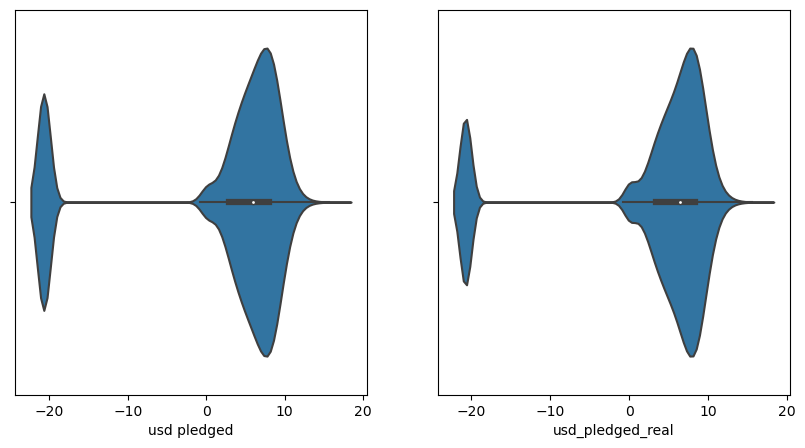

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.violinplot(np.log(ks_project_copy['usd pledged'] + 1e-9), ax=ax1)
sns.violinplot(np.log(ks_project_copy['usd_pledged_real'] + 1e-9), ax=ax2)

                   pledged  usd pledged  usd_pledged_real  usd_goal_real
pledged           1.000000     0.858153          0.953262       0.005067
usd pledged       0.858153     1.000000          0.908014       0.006244
usd_pledged_real  0.953262     0.908014          1.000000       0.005638
usd_goal_real     0.005067     0.006244          0.005638       1.000000



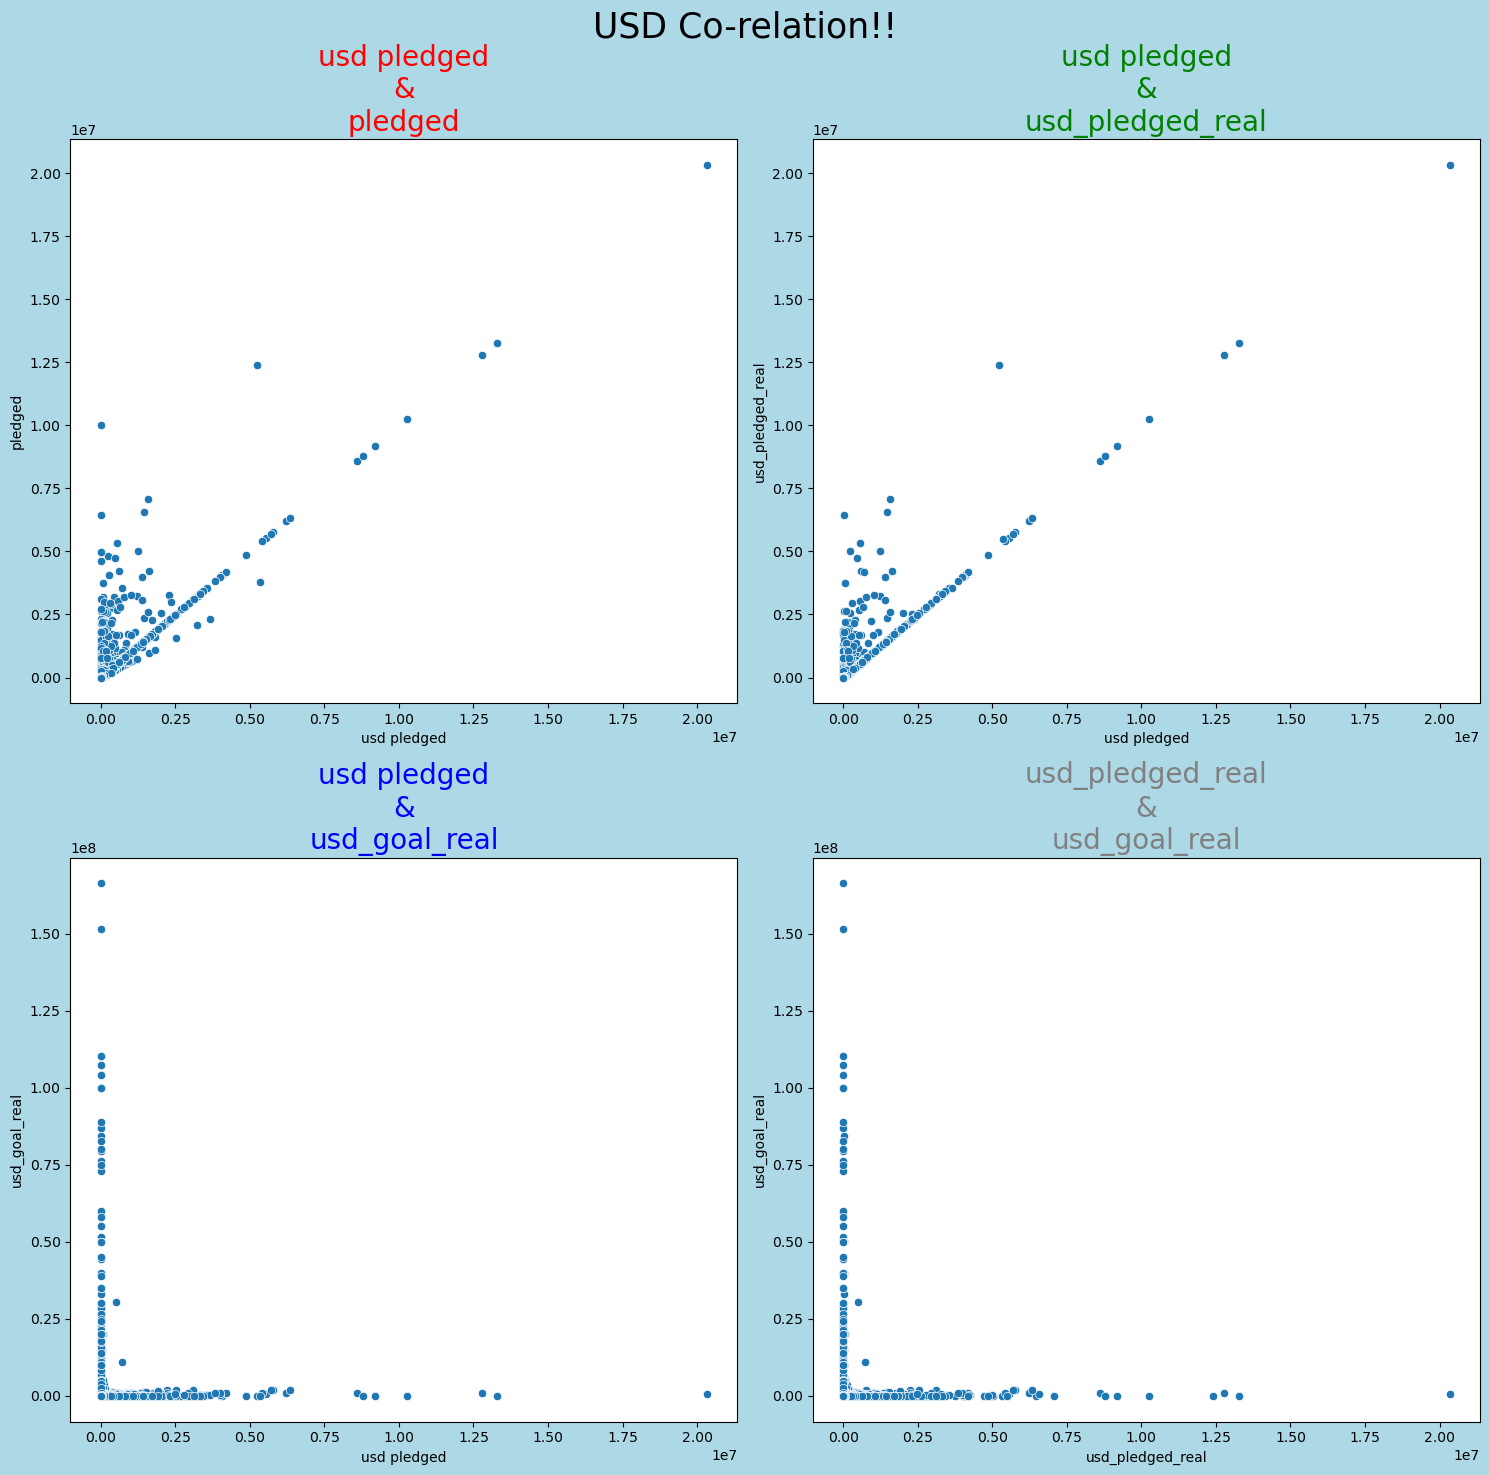

In [14]:
usd_df = ks_project_copy[['pledged', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']]
print(usd_df.corr())
print()

fig, axes = plt.subplots(2, 2, figsize=(15, 15), facecolor='lightblue')
sns.scatterplot(x='usd pledged', y='pledged', data=usd_df, ax=axes[0, 0])
sns.scatterplot(x='usd pledged', y='usd_pledged_real', data=usd_df, ax=axes[0,1])
sns.scatterplot(x='usd pledged', y='usd_goal_real', data=usd_df, ax=axes[1,0])
sns.scatterplot(x='usd_pledged_real', y='usd_goal_real', data=usd_df, ax=axes[1,1])

plt.suptitle('USD Co-relation!!', fontsize=25)
axes[0,0].set_title('usd pledged\n&\npledged', fontsize=20, color='red')
axes[0,1].set_title('usd pledged\n&\nusd_pledged_real', fontsize=20, color='green')
axes[1,0].set_title('usd pledged\n&\nusd_goal_real', fontsize=20, color='blue')
axes[1,1].set_title('usd_pledged_real\n&\nusd_goal_real', fontsize=20, color='gray')
plt.tight_layout()

# 우리는 'usd_pledged_real' 컬럼을 지울 수 있다.
- 'usd pledged' 컬럼과 상관관계가 90% 이상이기 때문.

In [15]:
ks_project_drop_real = ks_project_copy.drop('usd_pledged_real', axis=1)

<h2 style="text-align:center;"> 다음으로, 'goal' 컬럼의 분포도를 확인한다.</h2>

<AxesSubplot:xlabel='goal', ylabel='Count'>

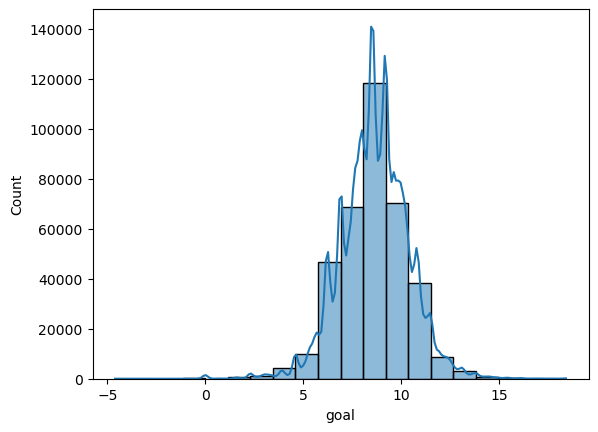

In [16]:
sns.histplot(np.log(ks_project_drop_real['goal'] + 1e-9), bins=20, kde=True)

음.. 표준분포 확인

                   goal  usd_goal_real
goal           1.000000       0.941676
usd_goal_real  0.941676       1.000000



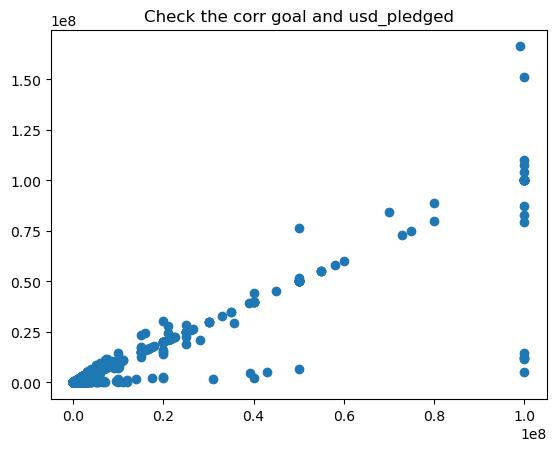

In [17]:
print(ks_project_drop_real[['goal', 'usd_goal_real']].corr())
print()
plt.scatter(ks_project_drop_real['goal'], ks_project_drop_real['usd_goal_real'])
plt.title('Check the corr goal and usd_pledged')
plt.show()

# 다시, 우리는 'goal' 컬럼의 유사도가 'usd_goal_real'와 유사하기 때문에 drop 시도해본다

In [18]:
ks_project_without_goal = ks_project_drop_real.drop(['goal', 'ID', 'name', 'country', 'deadline'], axis=1)

ks_project_without_goal['year'] = ks_project_without_goal['launched'].dt.year   # launched 연도 따로 컬럼화
ks_project_without_goal['month'] = ks_project_without_goal['launched'].dt.month # launched 달수 따로 컬럼화
ks_project_without_goal = ks_project_without_goal.drop('launched', axis=1)      # launched 컬럼 삭제
ks_project_without_goal.head()

,category,main_category,currency,pledged,state,backers,usd pledged,usd_goal_real,year,month
0,Poetry,Publishing,GBP,0.0,failed,0,0.0,1533.95,2015,8
1,Narrative Film,Film & Video,USD,2421.0,failed,15,100.0,30000.00,2017,9
2,Narrative Film,Film & Video,USD,220.0,failed,3,220.0,45000.00,2013,1
3,Music,Music,USD,1.0,failed,1,1.0,5000.00,2012,3
4,Film & Video,Film & Video,USD,1283.0,failed,14,1283.0,19500.00,2015,7


In [21]:
ks_project_without_goal.info()
ks_project_without_goal.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372062 entries, 0 to 378660
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   category       372062 non-null  object 
 1   main_category  372062 non-null  object 
 2   currency       372062 non-null  object 
 3   pledged        372062 non-null  float64
 4   state          372062 non-null  object 
 5   backers        372062 non-null  int64  
 6   usd pledged    372062 non-null  float64
 7   usd_goal_real  372062 non-null  float64
 8   year           372062 non-null  int64  
 9   month          372062 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 31.2+ MB


,category,main_category,currency,pledged,state,backers,usd pledged,usd_goal_real,year,month
320763,Tabletop Games,Games,GBP,1897.0,successful,43,959.41,629.00,2016,10
80250,Shorts,Film & Video,USD,5000.0,successful,26,5000.00,5000.00,2012,10
220127,Television,Film & Video,USD,0.0,failed,0,0.00,50000.00,2015,7
341281,Shorts,Film & Video,USD,450.0,failed,9,450.00,3000.00,2014,2
234914,Webseries,Film & Video,USD,200.0,failed,8,200.00,3500.00,2012,2
106576,Technology,Technology,GBP,7.0,failed,3,11.72,168041.81,2014,6
351983,Pop,Music,USD,3787.0,successful,68,3787.00,3000.00,2010,10
326953,Fashion,Fashion,USD,645.0,failed,15,645.00,1400.00,2012,4
95277,Fiction,Publishing,USD,159.0,failed,6,159.00,10000.00,2015,12
165604,Food Trucks,Food,USD,3175.0,successful,25,3175.00,3000.00,2014,9


# backer : 후원자에 대해 확인한다

In [37]:
ks_project_without_goal['backers']
# np.log(ks_project_without_goal['backers'] + 1e-9)
# np.log(1e-9) # -20
# np.log(1) # 0
# np.log(np.e)  # 지수로그는 1
# np.e  # 지수 e

2.718281828459045

0     51263
1     34530
2     22996
3     15929
4     11954
5      9642
6      8084
7      6946
8      6138
9      5492
10     5014
11     4500
12     4315
13     4101
14     3923
15     3701
16     3427
17     3405
18     3135
19     3126
Name: backers, dtype: int64


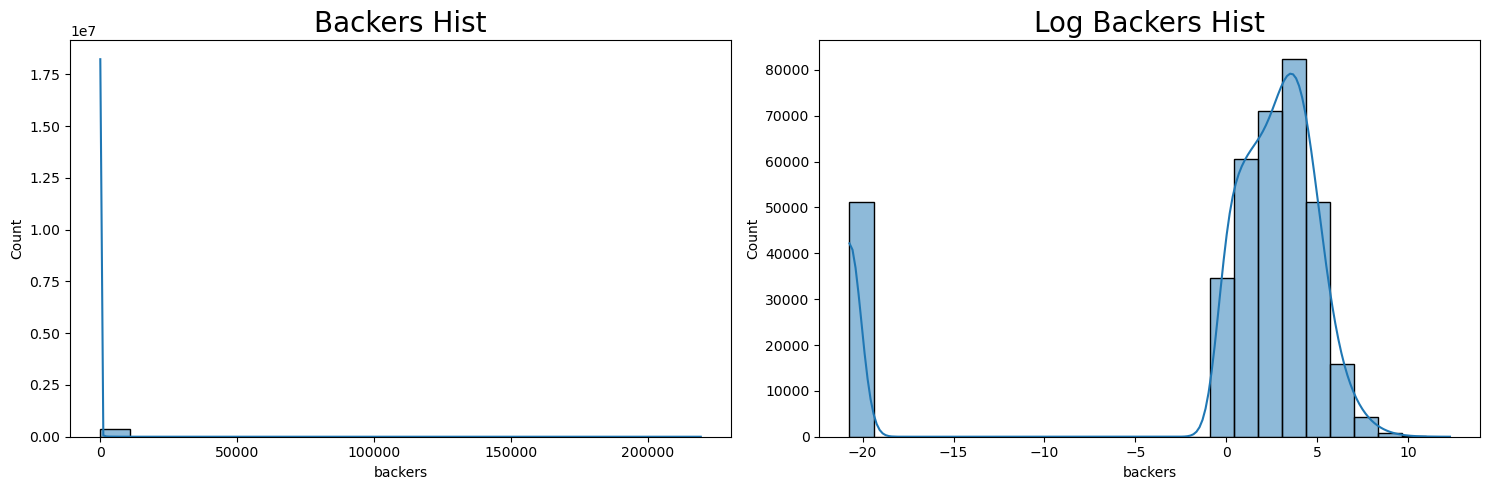

In [23]:
print(ks_project_without_goal['backers'].value_counts().sort_values(ascending=False)[:20])

fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(ks_project_without_goal['backers'], bins=20, kde=True, ax=axes[0])
sns.histplot(np.log(ks_project_without_goal['backers'] + 1e-9), bins=25, kde=True, ax=axes[1])
axes[0].set_title('Backers Hist', fontsize=20)
axes[1].set_title('Log Backers Hist', fontsize=20)
plt.tight_layout()
plt.show()

# 거의, 많은 후원들은 작지만 몇몇은 큰 숫자를 갖고있다

                pledged   backers  usd pledged  usd_goal_real
pledged        1.000000  0.718208     0.858153       0.005067
backers        0.718208  1.000000     0.697767       0.004542
usd pledged    0.858153  0.697767     1.000000       0.006244
usd_goal_real  0.005067  0.004542     0.006244       1.000000



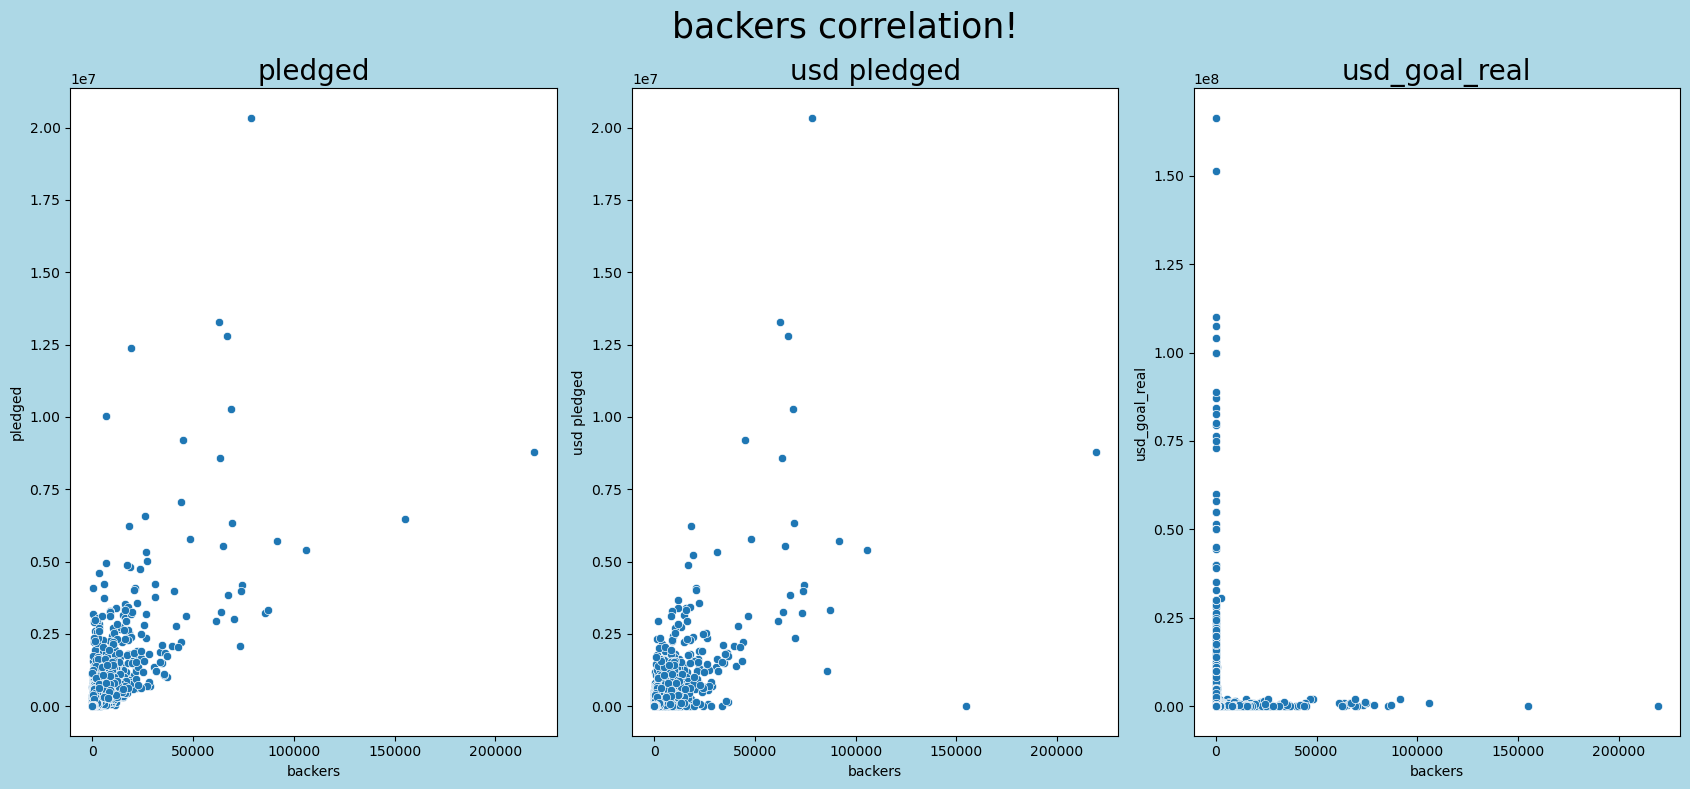

In [38]:
backers_df = ks_project_without_goal[['pledged', 'backers', 'usd pledged', 'usd_goal_real']]
print(backers_df.corr())
print()
fig, axes = plt.subplots(1, 3, figsize=(17, 8), facecolor='lightblue')
sns.scatterplot(x='backers', y='pledged', data=backers_df, ax=axes[0])
sns.scatterplot(x='backers', y='usd pledged', data=backers_df, ax=axes[1])
sns.scatterplot(x='backers', y='usd_goal_real', data=backers_df, ax=axes[2])

plt.suptitle('backers correlation!', fontsize=25)
axes[0].set_title('pledged', fontsize=20)
axes[1].set_title('usd pledged', fontsize=20)
axes[2].set_title('usd_goal_real', fontsize=20)
plt.tight_layout()
plt.show()

후원자들은 분석에 필요해보인다

# 카테고리컬 컬럼들과 정보를 확인한다

In [39]:
print('Main_category')
print(ks_project_without_goal.main_category.unique())
print(len(ks_project_without_goal.main_category.unique()))
print('-'*10)
print('category')
print(ks_project_without_goal.category.unique()[:10])
print(len(ks_project_without_goal.category.unique()))

Main_category
['Publishing' 'Film & Video' 'Music' 'Food' 'Design' 'Crafts' 'Games'
 'Comics' 'Fashion' 'Theater' 'Art' 'Photography' 'Technology' 'Dance'
 'Journalism']
15
----------
category
['Poetry' 'Narrative Film' 'Music' 'Film & Video' 'Restaurants' 'Food'
 'Drinks' 'Product Design' 'Documentary' 'Nonfiction']
159


<AxesSubplot:xlabel='main_category', ylabel='count'>

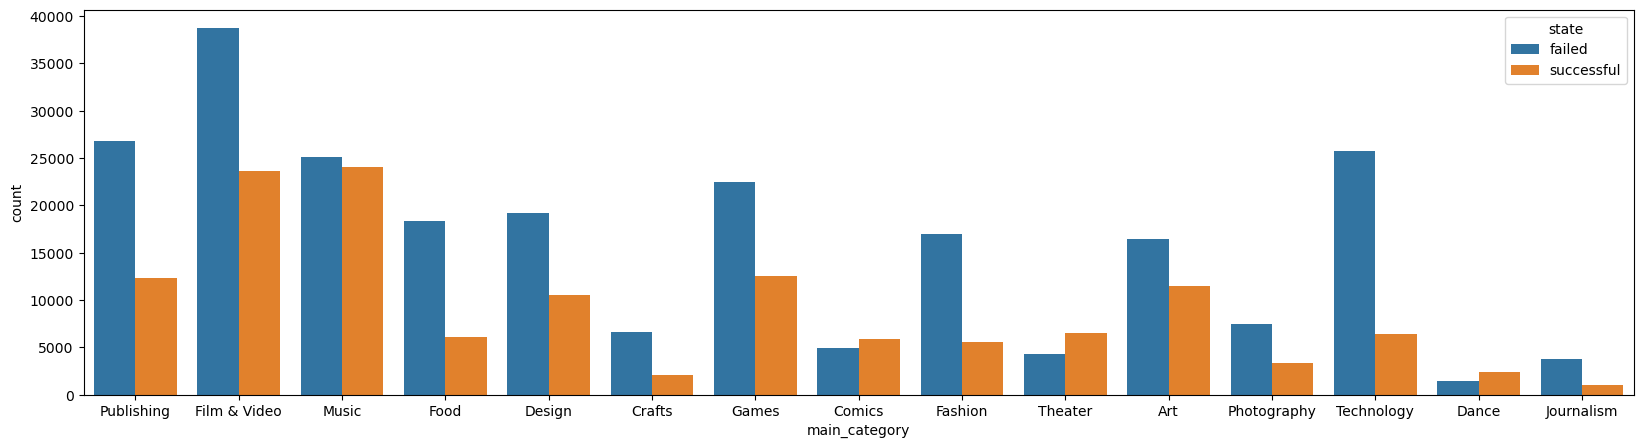

In [40]:
plt.figure(figsize=(20, 5))
sns.countplot(x='main_category', data=ks_project_without_goal, hue='state')

위의 그래프로 보니 Publishing, Film&Video, Food, Design, Games, Fashion, Technology 프로젝트는 실패가 명확히 많다

(만약 투자자라면 조심하자)

내 생각에 이 프로젝트들은 시작하기는 쉽지만, 이는 그 산업 분야에서 경쟁이 힘든 분야로 보인다

하지만 Music, Comics, Theater, Dance 분야는 성공 가능성이 높다.

이 카테고리에서 성공과 실패의 거리가 확실한걸 보자.

그건 Film&Video, Publishing, Food, Design, Games, Tech가 된다.

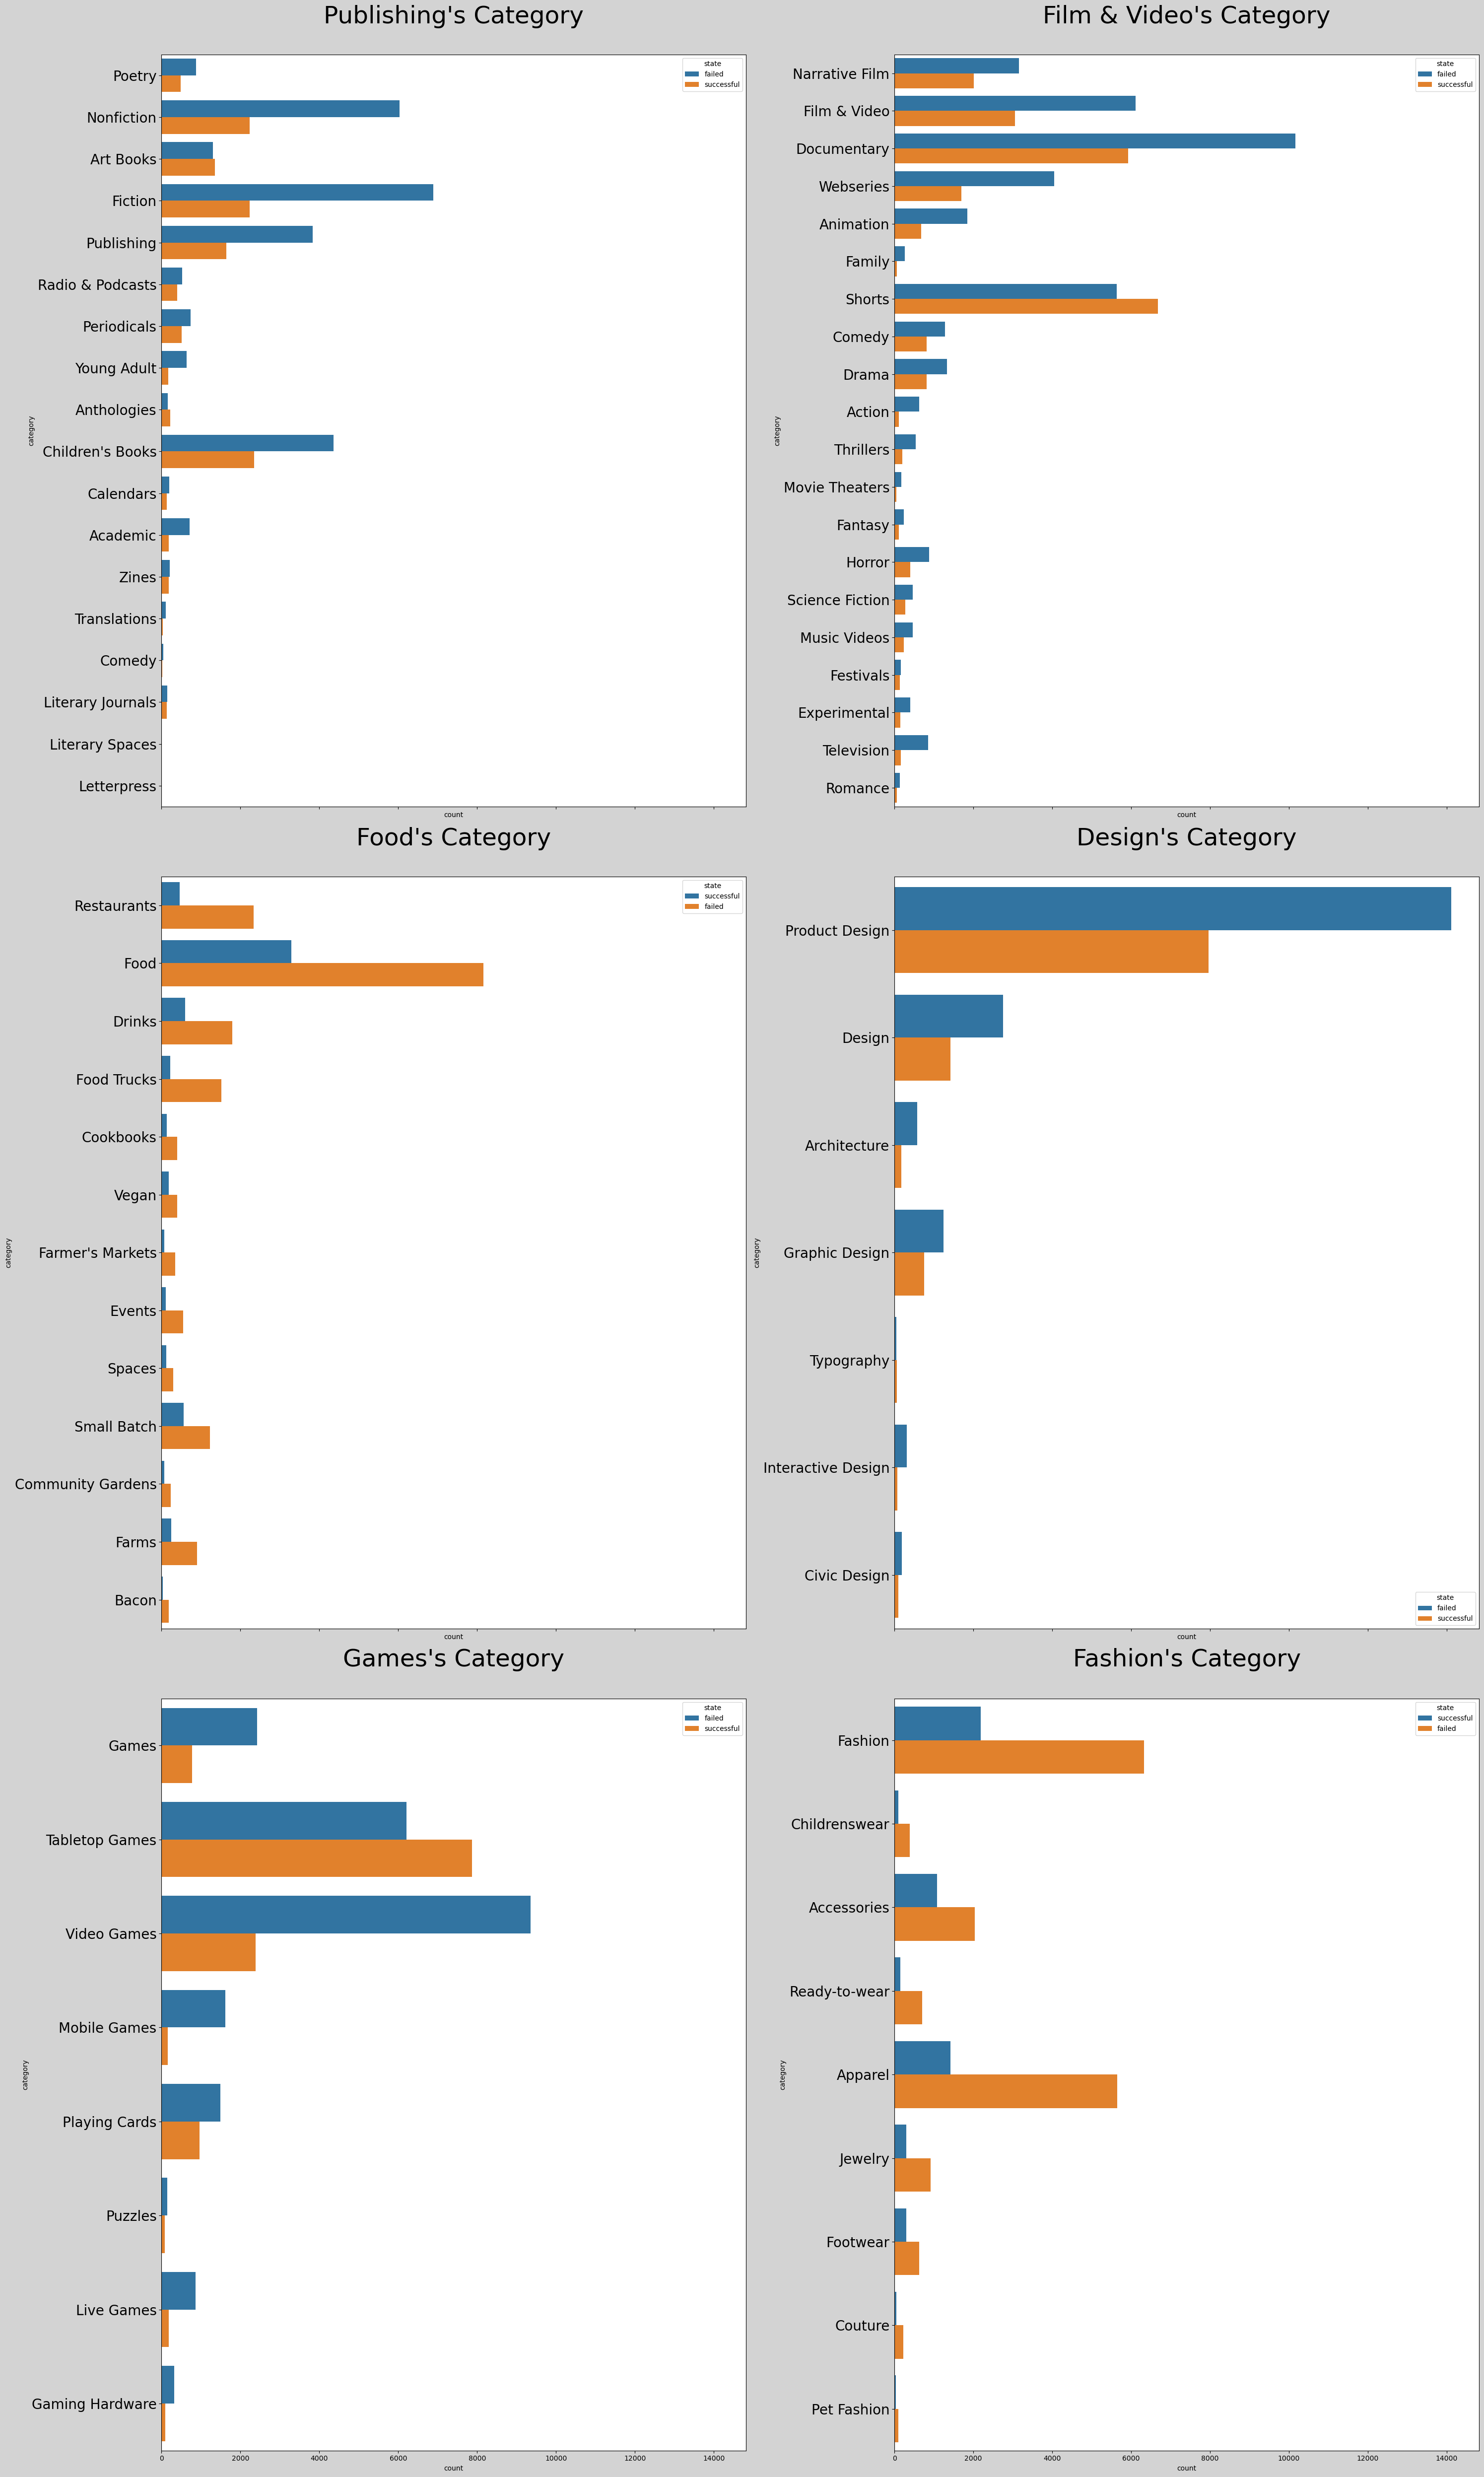

In [41]:
cols = ['Publishing', 'Film & Video', 'Food', 'Design', 'Games', 'Fashion', 'Technology']
indices = product([0, 1, 2], [0, 1])
fig, axes = plt.subplots(3, 2, figsize=(30, 50), sharex=True, facecolor='lightgray')

for idx, var in zip(indices, cols):
    var_data = ks_project_without_goal.query('main_category==@var')
    sns.countplot(y='category', data=var_data, hue='state', ax=axes[idx[0], idx[1]])
    axes[idx[0], idx[1]].set_title(f"{var}'s Category\n", fontsize=35)
    axes[idx[0], idx[1]].tick_params(axis='y', labelsize=20)

plt.tight_layout()
plt.show()

이 그래프는 메인 카테고리들이 실패하는 경향을 보인다

다만 몇몇 서브-카테고리들은 각 메인 카테고리에 비해 투자하기 좋아보인다

만약 당신이 투자자라면, 서브 카테고리도 확인해 봐야 한다.

# 다음으로 우리는 이 데이터에서 날짜의 중요성을 생각해봐야 한다!

In [42]:
ks_project_without_goal['year'].value_counts()

2015    74919
2014    66993
2016    56535
2017    49525
2013    44836
2012    41161
2011    26236
2010    10519
2009     1329
1970        7
2018        2
Name: year, dtype: int64

1970년 자료를 확인했다. 2018년 자료도 확인했다. 이 두 자료는 처리하기에 양도 적고 부정확하다.

그러니 두 데이터 형태는 삭제

In [43]:
ks_project_drop_dt = ks_project_without_goal.query('year != 1970 and year != 2018')
ks_project_drop_dt['year'].value_counts()

2015    74919
2014    66993
2016    56535
2017    49525
2013    44836
2012    41161
2011    26236
2010    10519
2009     1329
Name: year, dtype: int64

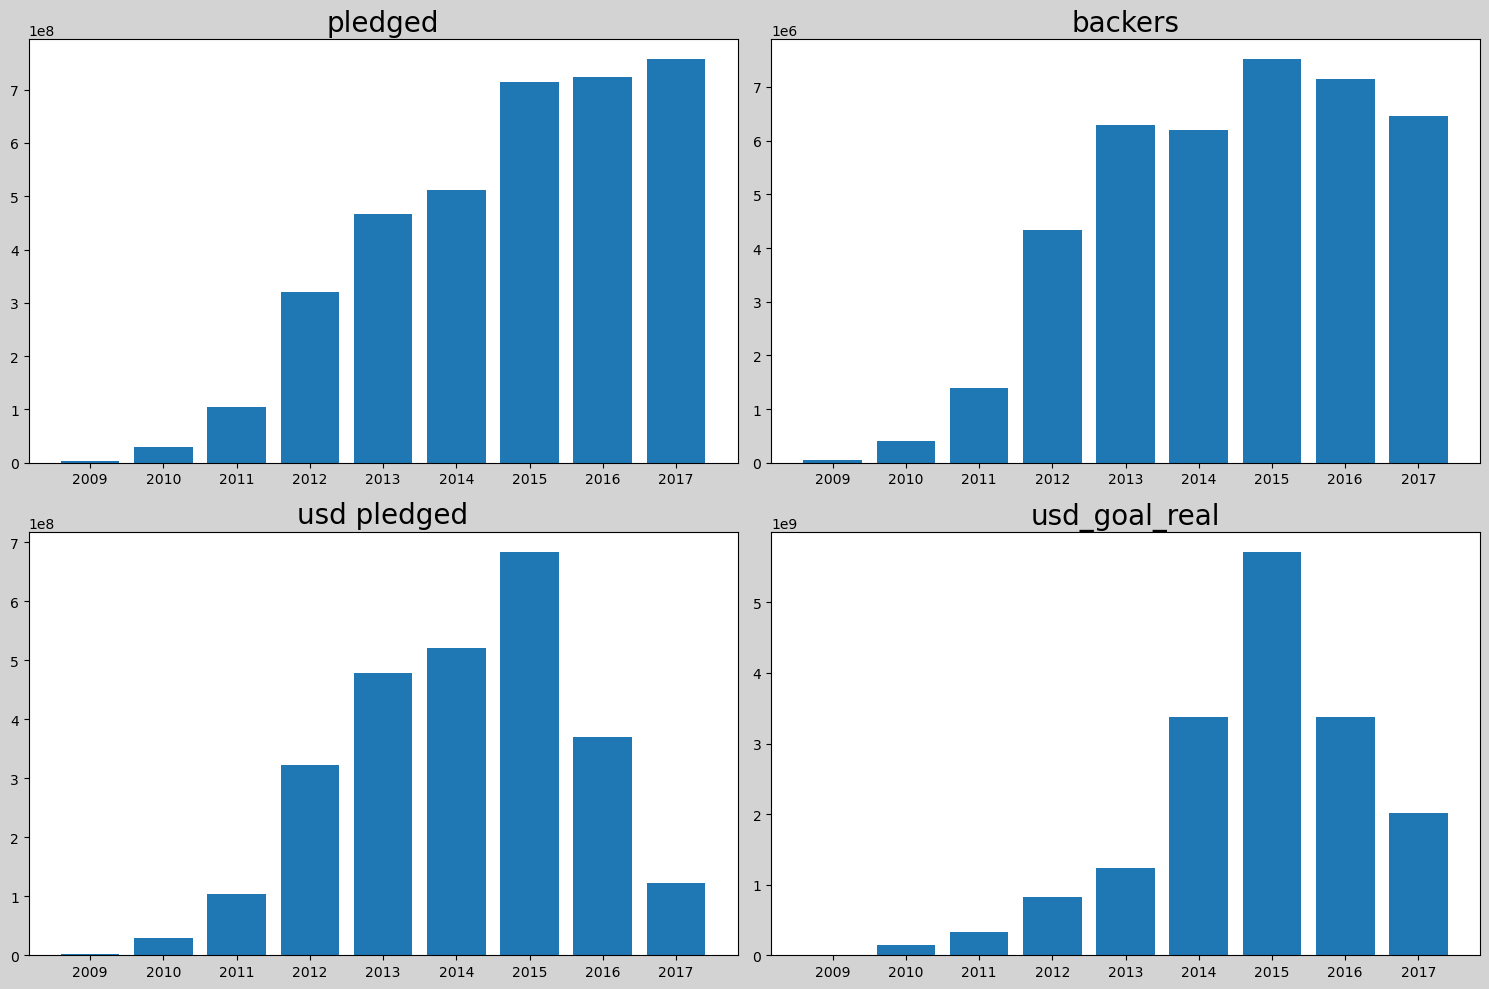

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), facecolor='lightgray')
grouby_df = ks_project_drop_dt.groupby('year').sum()
cols = ['pledged', 'backers', 'usd pledged', 'usd_goal_real']
indices = product([0, 1], [0, 1])

for idx, var in zip(indices, cols):
    axes[idx[0], idx[1]].bar(grouby_df.index, grouby_df[var])
    axes[idx[0], idx[1]].set_title(f'{var}', fontsize=20)
    axes[idx[0], idx[1]].set_xticks(grouby_df.index)
    axes[idx[0], idx[1]].tick_params(axis='x', labelsize=10)

plt.tight_layout()
plt.show()

목표 금액은 해마다 상승했다.

하지만 다른 컬럼의 연관관계는 없을까?

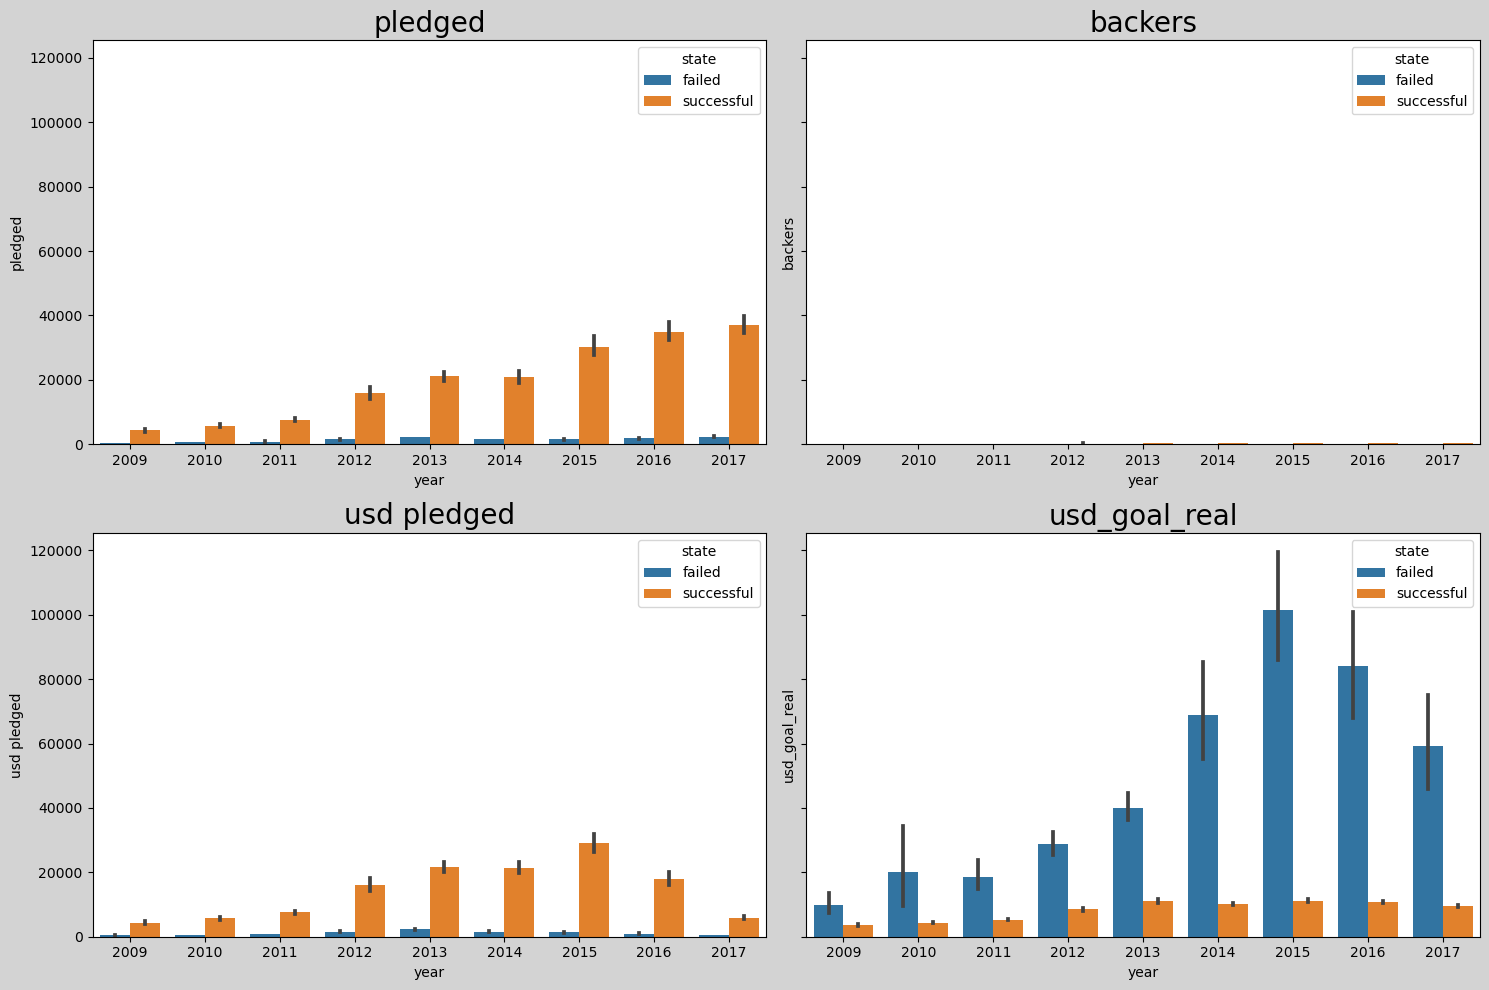

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True, facecolor='lightgray')
cols = ['pledged', 'backers', 'usd pledged', 'usd_goal_real']
indices = product([0, 1], [0, 1])

for idx, var in zip(indices, cols):
    sns.barplot(x='year', y=var, hue='state', data=ks_project_drop_dt, ax=axes[idx[0], idx[1]])
    axes[idx[0], idx[1]].set_title(f'{var}', fontsize=20)
    axes[idx[0], idx[1]].tick_params(axis='x', labelsize=10)

plt.tight_layout()
plt.show()
    

만약 성공을 원한다면, 목표 금액 설정에 주의하자!

- 왜 'pledged'와 ' amount of succesful'관련 파라미터가 연관이 높은지 알았다.
- 하지만 완전히 실패의 이유가 되지는 않아보인다!
- usd_goal_real이 심각한 영향을 끼치는걸 확인했다!

# 이제 머신러닝으로 넘어가본다

In [46]:
data = ks_project_drop_dt.copy()

# 데이터 분할
X = data.drop('state', axis=1)
X = pd.get_dummies(X, drop_first=True)  # 카테고리 컬럼을 숫자형으로 변경한다
y = data['state'].replace({'failed': 0, 'successful': 1})

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=123)

# 1 결정 트리를 사용한다

In [48]:
# standardscaler와 dicision을 사용하여 파이프라인을 구성한다.
decision_tree = DecisionTreeClassifier(max_depth=5, random_state=123)
decision_tree.fit(X_train, y_train)
scores = cross_val_score(estimator=decision_tree, X=X_train, y=y_train, cv=10)
print(np.mean(scores))
print(np.mean(decision_tree.score(X_val, y_val)))

0.9702494137031572
0.9702497942179442


In [52]:
X.columns
y.name

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            378651, 378652, 378653, 378654, 378655, 378656, 378657, 378658,
            378659, 378660],
           dtype='int64', length=372053)

In [ ]:
from sklearn.tree import export_graphviz
from graphviz import Source

g = export_graphviz(decision_tree,
                    out_file=None,
                    feature_names=X_train,
                    class_names=y_train,
                    rounded=True,
                    filled=True)

graph = Source(g)
graph

확실히 좋은 결과가 나왔다!

하지만, 이게 과적합인지 아닌지 알아봐야한다

# ROC Curve를 확인

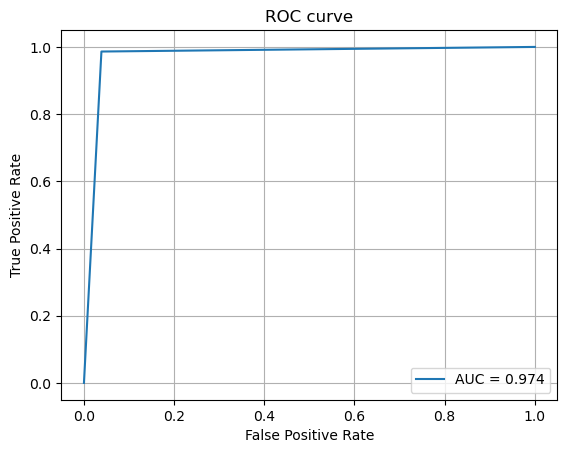

In [43]:
# ROC curve
pred = decision_tree.predict(X_val)
fpr, tpr, thresholds = roc_curve(y_val, pred)
auc_score = roc_auc_score(y_val, pred)

plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

ROC curve 깔끔하게 나왔다.

# 2 간단한 로지스틱을 실행해보자

In [ ]:
# seek the best param
param_dist = {'C': np.arange(0.01, 10, 0.5)}

rs = RandomizedSearchCV(estimator=LogisticRegression(), param_distributions=param_dist, cv=5, random_state=123)
rs.fit(X_train, y_train)
print(rs.score(X_val, y_val))
print(rs.best_params_)

이 모델은 제대로 작동하지 않는다. 하지만 우린 Log의 최적 파라미터를 우리가 앙상블(ensemble) 방법을 사용하면 얻을 수 있을거다

# 3 랜덤 포레스트

In [46]:
rf = RandomForestClassifier(random_state=123)
rf.fit(X_train, y_train)
print(rf.score(X_val, y_val))

0.9871827176670195


In [47]:
top5_importance_indices = np.argpartition(rf.feature_importances_, -10)[-10:]
print(top5_importance_indices)
print(X.columns[top5_importance_indices])

[190 176 173 118   1   5   4   3   2   0]
Index(['currency_USD', 'main_category_Technology', 'main_category_Music',
       'category_Product Design', 'backers', 'month', 'year', 'usd_goal_real',
       'usd pledged', 'pledged'],
      dtype='object')


이 모델은 결정트리보다 더 나아보인다.

그리고 10개의 특징(feature)를 잡았다.

우리가 EDA 전에 모델링부터 했다면, 키에서 예측하는 것은 실패에 가까웠을 것이다

# 마지막으로 우리는 앙상블 모델을 시도한다

마지막으로 우린 앙상블 시도해서 높은 점수 확인해본다

여기서는 에이다부스트, lightgbm, xgboost, 기타등등을 시도해서 흥미로운 것들을 제시할 것이다.

In [49]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=123)),
    ('svr', LinearSVC(random_state=123))
]

stack = StackingClassifier(estimators=estimators,
                            final_estimator=LogisticRegression(C=0.01, max_iter=30)
                        )

stack.fit(X_train, y_train)
y_pred = stack.predict(X_val)

print(stack.score(X_val, y_val))
print(accuracy_score(y_true=y_val, y_pred=y_pred))

0.9839406003796469
0.9839406003796469


이 모델은 결정 트리보다 낫지만, 결정트리는 rf보다 못합니다.

그래서, 우린 테스트 데이터에 rf model을 사용해야 합니다

In [50]:
accuracy_score(y_test, rf.predict(X_test))

0.9868567819274032

# 결론

## 1단계 : 데이터 확인 진행

우리는 null값이 작아질 때까지 보완 가능한 정보를 추가하고 null값이 영향을 주기 힘든 정도로 줄임

## 2단계 : EDA와 시각화
우리는 몇몇 변수를 봤고, 각 분포를 조정하고 각 컬럼이 어떤 영향력을 가지는지 확인.

우리는 각 카테고리가 실패에 가까워지는지, 아니면 서브 카테고리가 성공에 기여하는가 확인.

## 마지막 : 머신 러닝
우리는 다양한 접근을 시도했습니다. 그리고 결국 좋으 모델을 만들어냄

그리고 이 모델은 투자를 결정하기에 중요한 피처를 확인.
